In [1]:
#importing the required libraries
import numpy as np
import pandas as pd
import pickle
import matrix_factorization_utilities
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [2]:
# Reading the ratings data
ratings = pd.read_csv(r'C:\Users\kumari\Desktop\fintech\AI & ML\Movie-Recommendation-System-master\Dataset\ratings.csv')

In [3]:
#Just taking the required columns
ratings = ratings[['userId', 'movieId','rating']]

In [103]:
ratings

,userId,movieId,rating
0,0,1,3.5
1,0,28,3.5
2,0,31,3.5
3,0,46,3.5
4,0,49,3.5
5,0,109,3.5
6,0,146,4.0
7,0,217,4.0
8,0,247,4.0
9,0,254,4.0


In [4]:
# Checking if the user has rated the same movie twice, in that case we just take max of them
ratings_df = ratings.groupby(['userId','movieId']).aggregate(np.max)

In [5]:
#Getting the percentage count of each rating value 
count_ratings = ratings.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)

In [9]:
count_ratings

,userId,movieId,perc_total
rating,,,
0.5,13232,13232,1.3
1.0,35144,35144,3.4
1.5,14029,14029,1.3
2.0,74706,74706,7.1
2.5,44791,44791,4.3
3.0,226202,226202,21.6
3.5,112926,112926,10.8
4.0,295135,295135,28.1
4.5,79848,79848,7.6


In [6]:
#Visualising the percentage total for each rating
count_ratings['perc_total'].plot.bar()

In [7]:
#reading the movies dataset
movie_list = pd.read_csv(r'C:\Users\kumari\Desktop\fintech\AI & ML\Movie-Recommendation-System-master\Dataset\movies.csv')

In [8]:
# reading the tags datast
tags = pd.read_csv(r'C:\Users\kumari\Desktop\fintech\AI & ML\Movie-Recommendation-System-master\Dataset\tags.csv')

In [9]:
# inspecting various genres
genres = movie_list['genres']

In [10]:
genre_list = ""
for index,row in movie_list.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#inspect list of genres
new_list

['Thriller',
 'Fantasy',
 'Crime',
 'Sci-Fi',
 'Musical',
 '(no genres listed)',
 'Documentary',
 'War',
 'Animation',
 'Horror',
 'Mystery',
 'IMAX',
 'Comedy',
 'Western',
 'Film-Noir',
 'Children',
 'Drama',
 'Adventure',
 'Romance',
 'Action']

In [11]:
#Enriching the movies dataset by adding the various genres columns.
movies_with_genres = movie_list.copy()

for genre in new_list :
    movies_with_genres[genre] = movies_with_genres.apply(lambda _:int(genre in _.genres), axis = 1)

In [12]:
movies_with_genres.head()

,movieId,title,genres,Thriller,Fantasy,Crime,Sci-Fi,Musical,(no genres listed),Documentary,...,Mystery,IMAX,Comedy,Western,Film-Noir,Children,Drama,Adventure,Romance,Action
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [13]:
# Finding the average rating for movie and the number of ratings for each movie
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index

In [14]:
avg_movie_rating.reset_index(drop=True, inplace=True)

In [16]:
avg_movie_rating.head()

,mean,count,movieId
0,3.959323,2569,1
1,3.268398,1155,2
2,3.186861,685,3
3,3.000000,138,4
4,3.143836,657,5


In [17]:
#calculate the percentile count. It gives the no of ratings at least 70% of the movies have
np.percentile(avg_movie_rating['count'],70)

30.0

In [15]:
#Get the average movie rating across all movies 
avg_rating_all=ratings['rating'].mean()
avg_rating_all
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=30
min_reviews
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count,movieId
0,3.959323,2569,1
1,3.268398,1155,2
2,3.186861,685,3
3,3.000000,138,4
4,3.143836,657,5


In [16]:
#create a function for weighted rating score based off count of reviews
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [17]:
#Calculating the weighted score for each movie
movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
movie_score.head()

,mean,count,movieId,weighted_score
0,3.959323,2569,1,3.954359
1,3.268398,1155,2,3.275003
2,3.186861,685,3,3.201228
3,3.000000,138,4,3.094513
4,3.143836,657,5,3.160667


In [18]:
movie_score = pd.merge(movie_score,movies_with_genres,how ='inner',on='movieId')

In [23]:
movie_score

,mean,count,movieId,weighted_score,title,genres,Crime,Film-Noir,Adventure,Romance,...,War,IMAX,Animation,Children,Action,Horror,Thriller,Comedy,Mystery,(no genres listed)
0,3.959323,2569,1,3.954359,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0
1,3.268398,1155,2,3.275003,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,3.186861,685,3,3.201228,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,3.000000,138,4,3.094513,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3.143836,657,5,3.160667,Father of the Bride Part II (1995),Comedy,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,3.836508,1260,6,3.829363,Heat (1995),Action|Crime|Thriller,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
6,3.381429,700,7,3.387504,Sabrina (1995),Comedy|Romance,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7,3.352564,78,8,3.401650,Tom and Huck (1995),Adventure|Children,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
8,3.017327,202,9,3.083527,Sudden Death (1995),Action,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,3.427003,1548,10,3.428947,GoldenEye (1995),Action|Adventure|Thriller,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0


In [19]:
#list top scored movies over the whole range of movies
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])

,title,count,mean,weighted_score,genres
242,"Shawshank Redemption, The (1994)",3216,4.469994,4.461299,Crime|Drama
565,"Godfather, The (1972)",2137,4.388161,4.376270,Crime|Drama
46,"Usual Suspects, The (1995)",2490,4.370482,4.360468,Crime|Mystery|Thriller
403,Schindler's List (1993),2598,4.295612,4.286864,Drama|War
791,"Godfather: Part II, The (1974)",1418,4.278561,4.263037,Crime|Drama
3230,Band of Brothers (2001),228,4.353070,4.257280,Action|Drama|War
593,Casablanca (1942),1282,4.268721,4.251813,Drama|Romance
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151,Action|Adventure|Crime|Drama|Thriller
589,North by Northwest (1959),817,4.250306,4.224768,Action|Adventure|Mystery|Romance|Thriller
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788,Action|Crime|Drama|IMAX


In [20]:
# Gives the best movies according to genre based on weighted score which is calculated using IMDB formula
def best_movies_by_genre(genre,top_n):
    return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

In [21]:
#run function to return top recommended movies by genre
best_movies_by_genre('Musical',10)  

,title,count,mean,weighted_score
824,Duck Soup (1933),280,4.217857,4.151220
580,Singin' in the Rain (1952),542,4.097786,4.067969
3909,Dr. Horrible's Sing-Along Blog (2008),185,4.148649,4.062224
1777,Stop Making Sense (1984),119,4.142857,4.019316
2647,Fiddler on the Roof (1971),165,4.048485,3.968606
600,"Wizard of Oz, The (1939)",1229,3.947518,3.937552
588,"Gay Divorcee, The (1934)",57,4.149123,3.935381
1438,Nashville (1975),128,4.015625,3.923279
624,Top Hat (1935),120,4.004167,3.909188
3297,"Day at the Races, A (1937)",51,4.117647,3.899730


In [22]:
#merging ratings and movies dataframes
ratings_movies = pd.merge(ratings,movie_list, on = 'movieId')

In [23]:
ratings_movies.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [24]:
#Gets the other top 10 movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name):
    #get all users who watched a specific movie
    df_movie_users_series = ratings_movies.loc[ratings_movies['title']==movie_name]['userId']
    #convert to a data frame
    df_movie_users = pd.DataFrame(df_movie_users_series,columns=['userId'])
    #get a list of all other movies watched by these users
    other_movies = pd.merge(df_movie_users,ratings_movies,on='userId')
    #get a list of the most commonly watched movies by these other user
    other_users_watched = pd.DataFrame(other_movies.groupby('title')['userId'].count()).sort_values('userId',ascending=False)
    other_users_watched['perc_who_watched'] = round(other_users_watched['userId']*100/other_users_watched['userId'][0],1)
    return other_users_watched[:10]

In [25]:
# Getting other top 10 movies which are watched by the people who saw 'Gone Girl'
get_other_movies('Gone Girl (2014)')

,userId,perc_who_watched
title,,
Gone Girl (2014),61,100.0
"Matrix, The (1999)",54,88.5
Inception (2010),53,86.9
Fight Club (1999),52,85.2
"Shawshank Redemption, The (1994)",52,85.2
"Dark Knight, The (2008)",52,85.2
"Lord of the Rings: The Fellowship of the Ring, The (2001)",51,83.6
"Lord of the Rings: The Return of the King, The (2003)",50,82.0
Pulp Fiction (1994),48,78.7


In [26]:
#get ordered list of movieIds
item_indices = pd.DataFrame(sorted(list(set(ratings['movieId']))),columns=['movieId'])
#add in data frame index value to data frame
item_indices['movie_index']=item_indices.index
#inspect data frame
item_indices.head()


,movieId,movie_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [27]:
#get ordered list of movieIds
user_indices = pd.DataFrame(sorted(list(set(ratings['userId']))),columns=['userId'])
#add in data frame index value to data frame
user_indices['user_index']=user_indices.index
#inspect data frame
user_indices.head()

,userId,user_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [28]:
#join the movie indices
df_with_index = pd.merge(ratings,item_indices,on='movieId')
#join the user indices
df_with_index=pd.merge(df_with_index,user_indices,on='userId')
#inspec the data frame
df_with_index.head()

,userId,movieId,rating,movie_index,user_index
0,1,2,3.5,1,0
1,1,29,3.5,28,0
2,1,32,3.5,31,0
3,1,47,3.5,46,0
4,1,50,3.5,49,0


In [29]:
#import train_test_split module
from sklearn.model_selection import train_test_split
#take 80% as the training set and 20% as the test set
df_train, df_test= train_test_split(df_with_index,test_size=0.2)
print(len(df_train))
print(len(df_test))

838860
209715


In [38]:
df_train.head()

,userId,movieId,rating,movie_index,user_index
761590,4405,3147,4.0,2978,4404
671665,6089,1193,4.5,1140,6088
786338,6647,4787,4.0,4544,6646
51970,925,32,3.0,31,924
269178,4574,3623,4.0,3413,4573


In [33]:
df_test.head()

,userId,movieId,rating,movie_index,user_index
983564,948,4886,5.0,4637,947
537364,1963,1136,4.0,1088,1962
573718,3132,7842,3.5,7111,3131
752934,3776,55241,3.5,10079,3775
728832,1861,585,2.0,573,1860


In [30]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]
print(n_users)
print(n_items)

7120
14026


In [31]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_train.itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    train_data_matrix[line[5], line[4]] = line[3]
train_data_matrix.shape

(7120, 14026)

In [32]:
#Create two user-item matrices, one for training and another for testing
test_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_test[:1].itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    #print(line[2])
    test_data_matrix[line[5], line[4]] = line[3]
    #train_data_matrix[line['movieId'], line['userId']] = line['rating']
test_data_matrix.shape

(7120, 14026)

In [42]:
pd.DataFrame(train_data_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,14016,14017,14018,14019,14020,14021,14022,14023,14024,14025
0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
#Calculate the rmse sscore of SVD using different values of k (latent features)
rmse_list = []
#for i in [1,2,5,20,40,60,100,200]:
    #apply svd to the test data
u,s,vt = svds(train_data_matrix)
    #get diagonal matrix
s_diag_matrix=np.diag(s)
    #predict x with dot product of u s_diag and vt
X_pred = np.dot(np.dot(u,s_diag_matrix),vt)
    #calculate rmse score of matrix factorisation predictions

In [34]:
#Convert predictions to a DataFrame
mf_pred = pd.DataFrame(X_pred)
mf_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,14016,14017,14018,14019,14020,14021,14022,14023,14024,14025
0,1.083310,0.195497,-0.020626,-0.046965,-0.096783,0.655150,-0.070454,-0.030248,-0.021628,0.357170,...,0.001234,-0.000904,-0.003349,0.000052,0.0,0.0,0.000292,0.001766,-0.002466,0.0
1,0.784081,0.199153,0.057552,-0.013642,0.008806,0.365990,0.050524,0.007330,0.023922,0.360300,...,-0.000029,-0.000945,-0.004043,0.000059,0.0,0.0,-0.000557,0.000234,-0.002987,0.0
2,1.725723,0.121540,0.029970,-0.033406,-0.170277,1.076498,0.070312,-0.020881,0.008129,0.546620,...,-0.000473,-0.005127,-0.008783,0.000113,0.0,0.0,-0.004597,0.001441,-0.008710,0.0
3,0.518629,0.425245,0.242472,0.066389,0.238157,0.497435,0.240354,0.050848,0.122277,0.698870,...,-0.000756,0.000337,-0.001562,0.000008,0.0,0.0,0.000753,-0.000126,-0.000150,0.0
4,1.841366,0.884179,0.424231,0.110070,0.406869,0.475468,0.574015,0.105252,0.128373,1.110223,...,0.000372,0.000386,0.001952,0.000072,0.0,0.0,0.000127,0.000171,-0.000497,0.0


In [35]:
df_names = pd.merge(ratings,movie_list,on='movieId')
df_names.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [36]:
#choose a user ID
user_id = int(input('Enter User Id'))
#get movies rated by this user id
users_movies = df_names.loc[df_names["userId"]==user_id]
#print how many ratings user has made 
print("User ID : " + str(user_id) + " has already rated " + str(len(users_movies)) + " movies")
#list movies that have been rated
users_movies

Enter User Id567
User ID : 567 has already rated 31 movies


,userId,movieId,rating,title,genres
6335,567,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
17196,567,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
30921,567,593,5.0,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
48553,567,1196,5.0,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
50963,567,1198,5.0,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
55398,567,1208,5.0,Apocalypse Now (1979),Action|Drama|War
61367,567,1240,5.0,"Terminator, The (1984)",Action|Sci-Fi|Thriller
87384,567,2628,3.0,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
101360,567,3000,4.0,Princess Mononoke (Mononoke-hime) (1997),Action|Adventure|Animation|Drama|Fantasy
109041,567,4226,5.0,Memento (2000),Mystery|Thriller


In [71]:
user_index = df_train.loc[df_train["userId"]==user_id]['user_index'][:1].values[0]
#get movie ratings predicted for this user and sort by highest rating prediction
sorted_user_predictions = pd.DataFrame(mf_pred.iloc[user_index].sort_values(ascending=False))
#rename the columns
sorted_user_predictions.columns=['ratings']
#save the index values as movie id
sorted_user_predictions['movieId']=sorted_user_predictions.index
print("Top 10 Recommendations for User " + str(user_id))
#display the top 10 predictions for this user
pd.merge(sorted_user_predictions,movie_list, on = 'movieId')[:10]

Top 10 Recommendations for User 567


,ratings,movieId,title,genres
0,1.517874,254,Jefferson in Paris (1995),Drama
1,1.401048,1142,Get Over It (1996),Drama
2,1.332737,2422,"Karate Kid, Part III, The (1989)",Action|Adventure|Children|Drama
3,1.291580,290,Once Were Warriors (1994),Crime|Drama
4,1.286186,1144,"Line King: The Al Hirschfeld Story, The (1996)",Documentary
5,1.282531,824,Kaspar Hauser (1993),Drama|Mystery
6,1.197463,1155,"Invitation, The (Zaproszenie) (1986)",Drama
7,1.091404,1183,"English Patient, The (1996)",Drama|Romance|War
8,1.086703,581,"Celluloid Closet, The (1995)",Documentary
9,1.070614,312,Stuart Saves His Family (1995),Comedy


In [38]:
#count number of unique users
numUsers = df_train.userId.unique().shape[0]
#count number of unitque movies
numMovies = df_train.movieId.unique().shape[0]
print(len(df_train))
print(numUsers) 
print(numMovies) 

838860
7120
13433


In [39]:
#import libraries
import keras
from keras.layers import Embedding, Reshape, concatenate
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [52]:
from keras.utils import plot_model

In [40]:
# Couting no of unique users and movies
len(ratings.userId.unique()), len(ratings.movieId.unique())

(7120, 14026)

In [41]:
# Assigning a unique value to each user and movie in range 0,no_of_users and 0,no_of_movies respectively.
ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values

In [42]:
# Splitting the data into train and test.
train, test = train_test_split(ratings, test_size=0.2)

In [56]:
train.head()

,userId,movieId,rating
961393,6446,7743,4.0
688499,4564,1485,4.0
308904,2106,5166,2.5
879396,5872,432,3.0
78186,569,5217,4.0


In [57]:
test.head()

,userId,movieId,rating
584469,3915,107,3.5
796634,5313,4945,2.5
948195,6365,4298,5.0
447018,3036,578,4.0
301427,2065,170,3.0


In [43]:
n_users = len(ratings.userId.unique())
n_users

7120

In [44]:
n_movies =  len(ratings.movieId.unique())
n_movies

14026

In [45]:
# Returns a neural network model which performs matrix factorisation
from keras.layers import Input, Flatten, Dot
from keras.models import Model

movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies+1, 5, name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='Flatten-Movies')(movie_embedding)

user_input = Input(shape=[1],name='users')
user_embedding = Embedding(n_users+1, 5, name='User-Embedding')(user_input)
user_vec = Flatten(name='Flatten-Users')(user_embedding)

prod = Dot(name='Dot-Product', axes=1)([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error',metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.


In [47]:
import os
from keras.models import load_model
if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.userId, train.movieId], train.rating, epochs=10,verbose=1,batch_size=400,validation_split=0.2)

Train on 671088 samples, validate on 167772 samples
Epoch 1/10
671088/671088 [==============================] - 6s 9us/step - loss: 0.7775 - acc: 0.3432 - val_loss: 0.8364 - val_acc: 0.3397
Epoch 2/10
671088/671088 [==============================] - 6s 9us/step - loss: 0.7664 - acc: 0.3449 - val_loss: 0.8293 - val_acc: 0.3406
Epoch 3/10
671088/671088 [==============================] - 6s 9us/step - loss: 0.7586 - acc: 0.3451 - val_loss: 0.8234 - val_acc: 0.3406
Epoch 4/10
671088/671088 [==============================] - 6s 9us/step - loss: 0.7523 - acc: 0.3465 - val_loss: 0.8193 - val_acc: 0.3416
Epoch 5/10
671088/671088 [==============================] - 7s 10us/step - loss: 0.7472 - acc: 0.3470 - val_loss: 0.8150 - val_acc: 0.3409
Epoch 6/10
671088/671088 [==============================] - 6s 9us/step - loss: 0.7427 - acc: 0.3476 - val_loss: 0.8128 - val_acc: 0.3425
Epoch 7/10
671088/671088 [==============================] - 6s 9us/step - loss: 0.7386 - acc: 0.3483 - val_loss: 0.8098

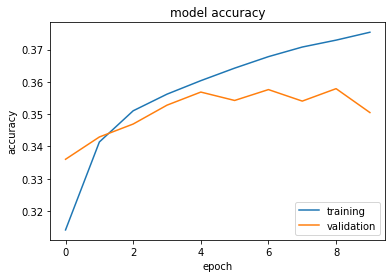

In [73]:
from matplotlib import pyplot 
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['training', 'validation'], loc='lower right')
pyplot.show()

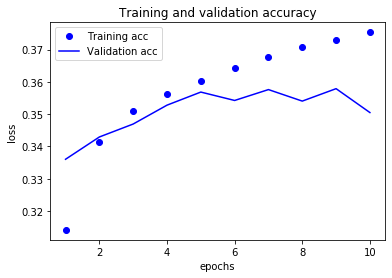

In [74]:
epochs=range(1, 11)
pyplot.clf()
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']
pyplot.plot(epochs, acc_values, 'bo', label='Training acc')
pyplot.plot(epochs, val_acc_values, 'b', label='Validation acc')
pyplot.title('Training and validation accuracy')
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.legend()
pyplot.show()

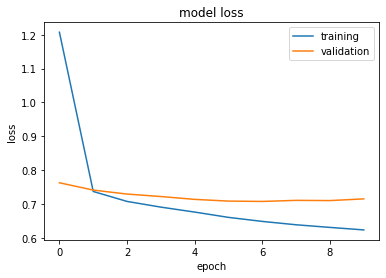

In [72]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['training', 'validation'], loc='upper right')
pyplot.show()


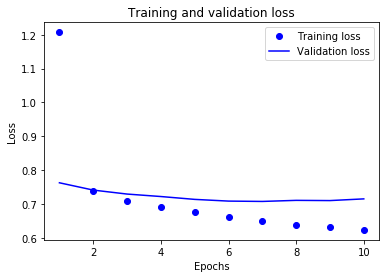

In [75]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
pyplot.plot(epochs, loss_values, 'bo', label='Training loss')
pyplot.plot(epochs, val_loss_values, 'b', label='Validation loss')
pyplot.title('Training and validation loss')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

In [51]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 5)         70135       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         35605       users[0][0]                      
____________________________________________________________________________________________

In [52]:
y_pred = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [53]:
print(y_pred)
print(y_true)

[[4.]
 [3.]
 [4.]
 ...
 [3.]
 [4.]
 [4.]]
279960     3.0
99937      4.0
411224     5.0
351721     4.0
308317     3.0
982031     4.5
729719     4.0
845137     4.0
5691       4.0
860868     4.0
489999     5.0
654341     3.5
356666     4.0
218258     3.0
224493     3.5
402014     4.0
325044     4.0
129402     4.0
238531     4.0
399650     2.0
584147     4.0
297778     4.5
812800     5.0
191907     5.0
1038014    3.5
847124     5.0
294948     5.0
638351     3.0
480334     4.0
57154      2.5
          ... 
646205     3.0
312454     4.0
66773      2.5
674880     4.0
769326     5.0
866242     3.5
292213     3.5
983515     4.0
659202     4.5
173583     3.5
920792     2.0
298702     5.0
219778     2.0
54577      5.0
627130     3.0
686445     3.0
499042     4.5
446586     3.0
797373     2.5
853879     4.0
698607     3.0
331133     2.0
226909     4.0
565196     3.0
359361     5.0
603551     1.0
482099     4.5
729285     3.5
363747     4.0
604798     4.5
Name: rating, Length: 209715, dtype: float6

In [54]:
from sklearn.metrics import mean_absolute_error
mbe = mean_absolute_error(y_true, y_pred)
print(mbe)

0.6685930906229883


In [55]:
from sklearn.metrics import mean_squared_error


mse = mean_squared_error(y_pred, y_true)

print(mse)

0.8755358462675535


In [56]:
from math import *
import math
rmse = math.sqrt(mse)
print(rmse)

0.9357007247339042


In [57]:
from keras.layers import Input, Flatten, Dot, Concatenate, Dense
from keras.models import Model

movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies+1, 5, name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='Flatten-Movies')(movie_embedding)

user_input = Input(shape=[1],name='users')
user_embedding = Embedding(n_users+1, 5, name='User-Embedding')(user_input)
user_vec = Flatten(name='Flatten-Users')(user_embedding)

conc = Concatenate()([movie_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, movie_input], out)
model2.compile('adam', 'mean_squared_error',metrics=['acc'])

In [58]:
from keras.models import load_model
if os.path.exists('regression_model2.h5'):
    model2 = load_model('regression_model2.h5')
else:
    history = model2.fit([train.userId, train.movieId], train.rating, epochs=10, verbose=1,batch_size=500,validation_split=0.2)

Train on 671088 samples, validate on 167772 samples
Epoch 1/10
671088/671088 [==============================] - 8s 11us/step - loss: 1.2075 - acc: 0.3142 - val_loss: 0.7626 - val_acc: 0.3360
Epoch 2/10
671088/671088 [==============================] - 8s 11us/step - loss: 0.7369 - acc: 0.3414 - val_loss: 0.7410 - val_acc: 0.3429
Epoch 3/10
671088/671088 [==============================] - 8s 11us/step - loss: 0.7075 - acc: 0.3511 - val_loss: 0.7293 - val_acc: 0.3470
Epoch 4/10
671088/671088 [==============================] - 9s 13us/step - loss: 0.6906 - acc: 0.3562 - val_loss: 0.7220 - val_acc: 0.3528
Epoch 5/10
671088/671088 [==============================] - 8s 12us/step - loss: 0.6760 - acc: 0.3604 - val_loss: 0.7135 - val_acc: 0.3568
Epoch 6/10
671088/671088 [==============================] - 8s 12us/step - loss: 0.6603 - acc: 0.3643 - val_loss: 0.7085 - val_acc: 0.3542
Epoch 7/10
671088/671088 [==============================] - 8s 12us/step - loss: 0.6484 - acc: 0.3678 - val_loss: 

Text(0, 0.5, 'Training Error')

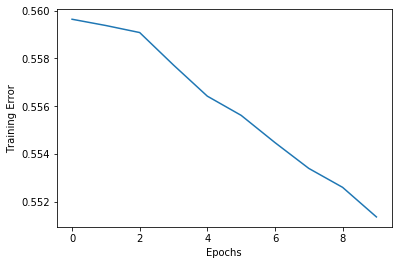

In [98]:
    import matplotlib.pyplot as plt
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [59]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 5)         70135       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         35605       users[0][0]                      
____________________________________________________________________________________________

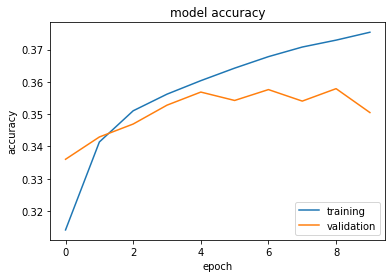

In [76]:
from matplotlib import pyplot 
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['training', 'validation'], loc='lower right')
pyplot.show()

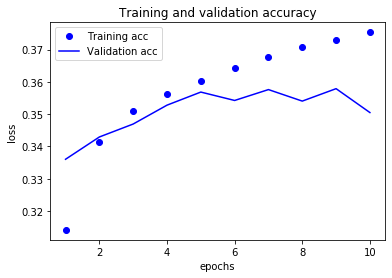

In [64]:
epochs=range(1, 11)
pyplot.clf()
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']
pyplot.plot(epochs, acc_values, 'bo', label='Training acc')
pyplot.plot(epochs, val_acc_values, 'b', label='Validation acc')
pyplot.title('Training and validation accuracy')
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.legend()
pyplot.show()

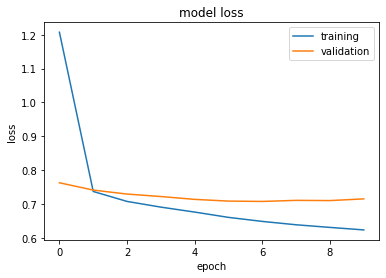

In [65]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['training', 'validation'], loc='upper right')
pyplot.show()


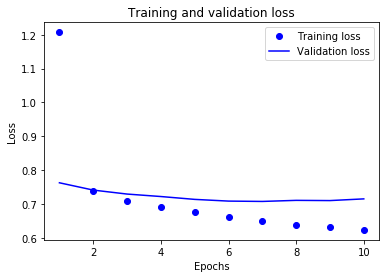

In [66]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
pyplot.plot(epochs, loss_values, 'bo', label='Training loss')
pyplot.plot(epochs, val_loss_values, 'b', label='Validation loss')
pyplot.title('Training and validation loss')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

In [67]:
y_pred = np.round(model2.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [68]:
from sklearn.metrics import mean_squared_error


mse = mean_squared_error(y_pred, y_true)

print(mse)

0.7910735998855589


In [69]:
from sklearn.metrics import mean_absolute_error
mbe = mean_absolute_error(y_true, y_pred)
print(mbe)

0.6386810671625778


In [70]:
from math import *
import math
rmse = math.sqrt(mse)
print(rmse)

0.889423183802603
